<a href="https://colab.research.google.com/github/hermanodfc/BSI-UFRPE/blob/master/Projeto_2_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FlyFood

## Configuração do Ambiente

### Instalação de bibliotecas extras
Instalação da versão mais recente da biblioteca [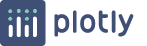](https://plotly.com/)

In [ ]:
%pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


### Import das bibliotecas utilizadas no projeto

In [ ]:
import plotly.graph_objects as go
import random
import collections
import math
from tqdm.notebook import tqdm
from time import sleep
import numpy as np
import scipy.special
import datetime

## Pontos de Entrega


### Ponto no plano cartesiano.

In [ ]:
Point = collections.namedtuple('Point', ['nome', 'x', 'y'])

### Distância euclidiana no plano cartesiano

In [ ]:
def distancia(a, b):
  return math.sqrt((b.x - a.x)**2 + (b.y - a.y)**2)

## Entradas do FlyFood


### Gerador de Entradas

In [ ]:
def gerador_entradas(qtd_pontos, formato, semente=None):
  random.seed(semente)
  pontos = [-1] + list(range(1, qtd_pontos))
  pontos += [0]*(formato[0]*formato[1] - len(pontos))
  random.shuffle(pontos)

  result = []

  for i in range(0, formato[0]):
    lim_inf = (i * formato[1])
    lim_sup = lim_inf + formato[1]
    result.append(pontos[lim_inf:lim_sup])

  return result

### Processador de Entradas

In [ ]:
def processa_entrada(entrada):
  visitas = []
  origem = None

  for i in range(len(entrada)):
    linha_i = entrada[i]
    for j in range(len(linha_i)):
      ponto = linha_i[j]
      if ponto != 0:
        if ponto == -1:
          origem = Point(ponto, j, i)
        else:
          visitas.append(Point(ponto, j, i)) 

  return origem, visitas

##Circuítos

### Gerando circuítos sem inverso

In [ ]:
def gera_circuitos(visitas, caminho, posicao):

    if len(visitas) == 0:
        yield
    else:
        for i in range(len(visitas)):
            caminho[posicao] = visitas[i]
            yield from gera_circuitos(visitas[0:i] + visitas[i + 1:], caminho, posicao + 1)

def gera_circuitos_sem_inverso(visitas):

    if len(visitas) < 3:
        yield visitas[:]
    else:
        caminho = [0] * len(visitas)
        for i in range(len(visitas) - 1):
            caminho[0] = visitas[i]
            for j in range(i + 1, len(visitas)):
                caminho[-1] = visitas[j]
                for a in gera_circuitos(visitas[0:i] + visitas[i + 1:j] + visitas[j+1:], caminho, 1):
                    yield caminho[:]


### Custo (distância) de um circuíto

In [ ]:
def distancia_circuito(origem, caminho):
  custo_total = 0
  
  for i in range(len(caminho) - 1):
    custo_total += distancia(caminho[i], caminho[i + 1])
  
  custo_total += distancia(origem, caminho[0])
  custo_total += distancia(caminho[-1], origem)

  return custo_total

### Buscando o melhor (ou pior) circuíto

In [ ]:
def melhor_circuito(origem, visitas, verbose=False, informa_pior=False):
  melhor_custo = float('inf')
  melhor_caminho = None

  if informa_pior:
    pior_custo = float('-inf')
    pior_caminho = None
     
  if verbose:
    interval = 1000
    iter = 0
    espaco_busca = math.factorial(len(visitas))//2 
    pbar = tqdm(total=espaco_busca)
    
  for caminho in gera_circuitos_sem_inverso(visitas):
    distancia = distancia_circuito(origem, caminho)
    if distancia < melhor_custo:
      melhor_custo = distancia
      melhor_caminho = caminho

    if informa_pior:
      if distancia > pior_custo:
          pior_custo = distancia
          pior_caminho = caminho

    if verbose:
      iter += 1

      if iter % interval == 0:
        pbar.set_postfix(melhor_custo=melhor_custo, refresh=False)

        if informa_pior:
          pbar.set_postfix(melhor_custo=melhor_custo, pior_custo=pior_custo, refresh=False)
        pbar.update(interval)

  if verbose:
    pbar.update(espaco_busca % interval)
    pbar.close()

  if informa_pior:
    return melhor_custo, melhor_caminho, pior_custo, pior_caminho
  else:
    return melhor_custo, melhor_caminho

### Visualizando um circuito

In [ ]:
def criar_grafico(origem, caminho, custo, mensagem):

  caminho = [origem] + caminho + [origem]

  primeiro = go.Scatter(x=[ponto.x for ponto in caminho], 
                        y=[ponto.y for ponto in caminho],
                        mode="markers+text",
                        textposition="top center",
                        text = [str(ponto.nome) for ponto in caminho],
                        marker={'size':[10]*len(caminho),
                                'color': ['red'] + 
                                        ['blue']*(len(caminho) - 2) + 
                                        ['red']}) 

  frames = [go.Frame(data=[primeiro])]

  for i in range(2, len(caminho) + 1):
    posicoes = [(caminho[j].x, caminho[j].y) for j in range(i)]
    x, y = zip(*posicoes)

    frames.append(
        go.Frame(data=[primeiro, go.Scatter(x=x, y=y, mode="lines")])
    )


  fig = go.Figure(
      data=[primeiro, primeiro],
      layout=go.Layout(showlegend=False, title="Custo do {} caminho: {:.4f} unidades".format(mensagem, custo),
          xaxis=dict(range=[-1, len(matrix[0])], autorange=False, 
                    side='top', visible=False, showticklabels=False),
          yaxis=dict(range=[len(matrix) + 1, -2], autorange=False,
                    visible=False, showticklabels=False),
          updatemenus=[dict(
              type="buttons",
              buttons=[dict(label="Play",
                            method="animate",
                            args=[None])])]
      ),
      frames=frames
  )

  fig.show()

## Experimentos

In [ ]:
#@title Gerando uma matriz de entrada { run: "auto" }
Locais = 13 #@param {type:"integer"}
Linhas = 10 #@param {type:"integer"}
Colunas = 10 #@param {type:"integer"}
Semente_randomica =   19#@param {type:"integer"}
#@markdown  **Semente_randomica = 0 -> None**

if Semente_randomica == 0:
  Semente_randomica = None
  
matrix = gerador_entradas(Locais, (Linhas, Colunas), semente=Semente_randomica)
matrix

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 4, 0, 0, 0, 0, 3, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 11, 0, 0],
 [0, 0, 7, 0, 0, -1, 0, 0, 0, 0],
 [0, 8, 0, 0, 0, 6, 0, 0, 0, 0],
 [0, 0, 0, 10, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 12, 0, 0],
 [0, 0, 0, 0, 9, 0, 0, 2, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]]

### Processando a matriz de entrada

In [ ]:
origem, visitas = processa_entrada(matrix)
print(' Origem:\n\t', origem, '\n', 'Visitas:', *['\n\t '+ str(visita) for visita in visitas])

 Origem:
	 Point(nome=-1, x=5, y=3) 
 Visitas: 
	 Point(nome=1, x=0, y=0) 
	 Point(nome=4, x=1, y=1) 
	 Point(nome=3, x=6, y=1) 
	 Point(nome=11, x=7, y=2) 
	 Point(nome=7, x=2, y=3) 
	 Point(nome=8, x=1, y=4) 
	 Point(nome=6, x=5, y=4) 
	 Point(nome=10, x=3, y=5) 
	 Point(nome=12, x=7, y=6) 
	 Point(nome=9, x=4, y=7) 
	 Point(nome=2, x=7, y=7) 
	 Point(nome=5, x=8, y=9)


### Buscando circuito

In [ ]:
custo_otimo, circuito_otimo, pior_custo, pior_circuito = melhor_circuito(origem, visitas, verbose=True, informa_pior=True)
print(' Custo do melhor circuíto:', custo_otimo, '\n', 'Circuíto:', *['\n\t '+ str(visita) for visita in circuito_otimo])
print()
print(' Custo do pior circuíto:', pior_custo, '\n', 'Circuíto:', *['\n\t '+ str(visita) for visita in pior_circuito])



 Custo do melhor circuíto: 30.806306184662226 
 Circuíto: 
	 Point(nome=11, x=7, y=2) 
	 Point(nome=3, x=6, y=1) 
	 Point(nome=1, x=0, y=0) 
	 Point(nome=4, x=1, y=1) 
	 Point(nome=7, x=2, y=3) 
	 Point(nome=8, x=1, y=4) 
	 Point(nome=10, x=3, y=5) 
	 Point(nome=9, x=4, y=7) 
	 Point(nome=5, x=8, y=9) 
	 Point(nome=2, x=7, y=7) 
	 Point(nome=12, x=7, y=6) 
	 Point(nome=6, x=5, y=4)

 Custo do pior circuíto: 84.71027031935341 
 Circuíto: 
	 Point(nome=9, x=4, y=7) 
	 Point(nome=3, x=6, y=1) 
	 Point(nome=10, x=3, y=5) 
	 Point(nome=11, x=7, y=2) 
	 Point(nome=8, x=1, y=4) 
	 Point(nome=6, x=5, y=4) 
	 Point(nome=7, x=2, y=3) 
	 Point(nome=12, x=7, y=6) 
	 Point(nome=4, x=1, y=1) 
	 Point(nome=2, x=7, y=7) 
	 Point(nome=1, x=0, y=0) 
	 Point(nome=5, x=8, y=9)


In [ ]:
#@title Visualizando o circuito { run: "auto" }
Pior_caminho = True #@param {type:"boolean"}

circuito = circuito_otimo
custo = custo_otimo
mensagem = "melhor"
if Pior_caminho:
  circuito = pior_circuito
  custo = pior_custo
  mensagem = "pior"

criar_grafico(origem, circuito, custo, mensagem)

## Tempo de Execução

(Considerando a capacidade de processamento de um computador AMD Ryzen 5 2600 3.4GHz.)

### Análise do tempo de execução

In [ ]:
#@markdown
verificado = [[1, 0.000039],      
              [2, 0.000057], 
              [3, 0.000142], 
              [4, 0.000534],
              [5, 0.001510], 
              [6, 0.003867], 
              [7, 0.047474], 
              [8, 0.099958], 
              [9, 0.888257], 
              [10, 9.059275], 
              [11, 101.434492],
              [12, 1259.933144], 
              [13, 16827.891443]]

X = np.linspace(0, 14, 500)
Y = scipy.special.gamma(X + 1) * 2.701967902460184e-06

x, y = zip(*verificado)

fig = go.Figure()
fig.update_xaxes(dtick=1, title="Tamanho da Entrada")
fig.update_yaxes(range=[0, 18000], title="Tempo de Execução em Segundos")
fig.add_trace(go.Scatter(x=X, y=Y, mode='lines', name='Aproximação fatorial'))
fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Tempo Verificado'))
fig.update_layout(showlegend=False, title={
        'text': "<b>Variação do Tempo de Execução X Tamanho da Entrada</b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font' : {'size': 18}
        })

fig.show()

### Estimando o tempo necessário para execução

In [ ]:
#@markdown
print("Tam. Entrada\t\t\tTempo")
for i in range (5, 21):
  d = datetime.timedelta(seconds=2.701967902460184e-06 * math.factorial(i))
  print("{:6}\t\t{:6}y, {:2}m, {:2}d, {:02}:{:02}:{:02}.{:06}".format(i, 
        d.days//365, d.days%365//30, d.days%365%30, d.seconds//(60*60), 
        d.seconds%(60*60)//60, d.seconds%(60*60)%60, d.microseconds))

Tam. Entrada			Tempo
     5		     0y,  0m,  0d, 00:00:00.000324
     6		     0y,  0m,  0d, 00:00:00.001945
     7		     0y,  0m,  0d, 00:00:00.013618
     8		     0y,  0m,  0d, 00:00:00.108943
     9		     0y,  0m,  0d, 00:00:00.980490
    10		     0y,  0m,  0d, 00:00:09.804901
    11		     0y,  0m,  0d, 00:01:47.853912
    12		     0y,  0m,  0d, 00:21:34.246948
    13		     0y,  0m,  0d, 04:40:25.210330
    14		     0y,  0m,  2d, 17:25:52.944614
    15		     0y,  1m, 10d, 21:28:14.169206
    16		     1y,  9m, 19d, 07:31:46.707295
    17		    30y,  5m, 23d, 08:00:14.024007
    18		   548y,  6m, 20d, 00:04:12.432121
    19		 10422y,  5m,  0d, 01:19:56.210266
    20		208448y,  2m, 21d, 02:38:44.205078
